In [5]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [34]:
def read_log(fn):
    parts = []
    log = open(fn)
    while True:
        expr = log.readline()
        time_line = log.readline()
        if not expr or not time_line:
            break
        if "Test" in time_line or "Training" in time_line:
            train = time_line
            test = log.readline()
            log.readline() # train metrics
            if not log.readline(): # test metrics
                break
            parts.append((expr, train, test))
        else:
            if not "FAILED" in time_line:
                parts.append((expr, time_line, None))
                log.readline() # blank line
    return parts

In [35]:
log = read_log("mllib_perf_output__2016-06-01_17-51-25")

In [68]:
def parse_time(line):
    time_re = ".*[Tt]ime: (?P<median>\d+\.\d+),.*"
    time_re = re.compile(time_re)
    match = time_re.match(line)
    assert match
    return match.group("median")
    
for expr, time1, time2 in log:
    if time2 is not None:
        train_median = parse_time(time1)
        test_median = parse_time(time2)
    else:
        time_median = parse_time(time1)

In [69]:
def read_stats_log(fn):
    log = open(fn)
    times, mems = [], []
    while True:
        line = log.readline()
        if not line:
            break
        time_re = re.compile("time (?P<epoch>\d+)")
        match = time_re.match(line)
        if match:
            if not log.readline():
                break
            stats_line = log.readline()
            if not stats_line:
                break
            stats_line = stats_line.split()
            mem_usage = float(stats_line[2])
            if stats_line[3] == "MB":
                mem_usage = mem_usage / 1024.0
            else:
                assert stats_line[3] == "GB"
            epoch = int(match.group("epoch"))
            times.append(epoch)
            mems.append(mem_usage)
    return pd.DataFrame({'time': times, 'mem_usage': mems})

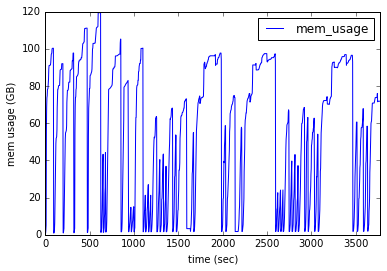

In [70]:
df = read_stats_log("stats.log")
df["time"] = df["time"] - df.time.min()
ax = df.plot(x='time', y='mem_usage')
ax.set_ylabel("mem usage (GB)")
ax.set_xlabel("time (sec)")